We played around with the London transit data, exploring what it tells us about where people live and comparing it to the census estimation. We have the aim down to two components, or key questions:

1. What is the relationship between population and ridership?
1. What does the ridership of a station tell us about the overall transit network?

In this section we will delve deeper into the first question, and we address the second in another section. But the two problems are very related: if we can reliably extract population from network transit data, we can use this to classify areas into residential and business districts, and vice versa.

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, spatial
from sklearn import preprocessing
import shapely
import seaborn as sns

## Data

Once again we start by getting the necessary data:
* London station names and locations
* London ward shapes
* London ward/borough census

#### Entrance/Exit Counts

In [2]:
PROJECTION=32630

In [3]:
counts_en = pd.read_csv('../data/london/counts/En17week_mod.csv', skiprows=6).set_index(' Station')
counts_ex = pd.read_csv('../data/london/counts/Ex17week.csv', skiprows=6).set_index(' Station')

# We only care about the time columns
time_columns = counts_en.columns[3:-8]

# Easier to work with stations as columns, so transpose
data_en = counts_en.loc[:, time_columns].T
data_ex = counts_ex.loc[:, time_columns].T

# Remove "Total" column
data_en.drop('Total',axis=1,inplace=True)
data_ex.drop('Total',axis=1,inplace=True)

# Extract the first time
data_en.index = data_en.index.str[:4]
data_ex.index = data_en.index.str[:4]

# Convert to datetime format
data_en.index = pd.to_datetime(data_en.index, format='%H%M')
data_ex.index = pd.to_datetime(data_en.index, format='%H%M')

# Create a time of day index that we can use from now on
morning_start = '6:00:00'
morning_end = '11:00:00'
off_start = '11:00:00'
off_end = '15:00:00'
afternoon_start = '15:00:00'
afternoon_end = '20:00:00'

# Get the timedelta
delta = data_en.index.to_perioddelta('15M')
# Prepare the time_of_day index
time_of_day = delta.to_series()
# First, assume everything at night
time_of_day[:] = 'night'
# If between the defined times, set to morning, afternoon, etc.
time_of_day[(delta > pd.to_timedelta(morning_start)) & (delta <= pd.to_timedelta(morning_end))] = 'morning'
time_of_day[(delta > pd.to_timedelta(off_start)) & (delta <= pd.to_timedelta(off_end))] = 'off'
time_of_day[(delta > pd.to_timedelta(afternoon_start)) & (delta <= pd.to_timedelta(afternoon_end))] = 'afternoon'
# Convert to index
time_of_day = pd.Index(time_of_day)

Correlation matrix of the entrances across time for all stations. Can see distinct areas of stronger correlation.

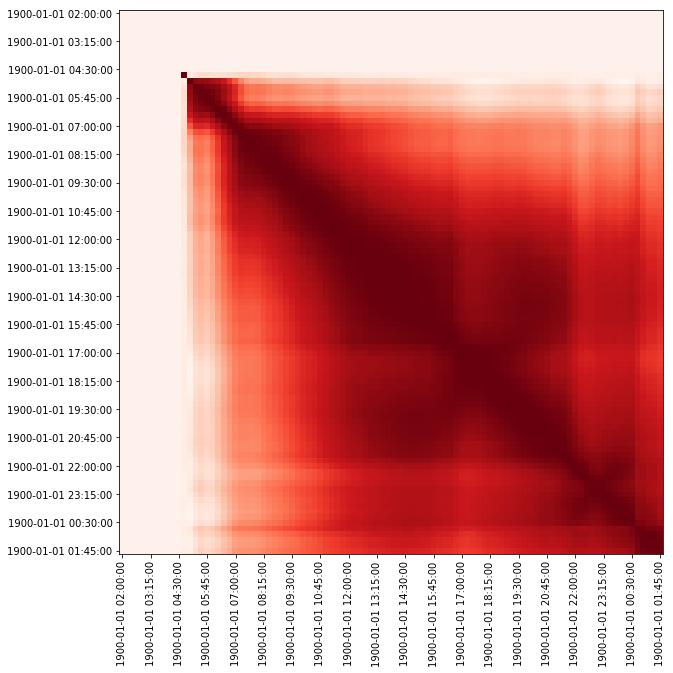

In [4]:
f,ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(data_en.T.corr().fillna(0), cmap='Reds')
ticks = range(0,data_en.shape[0],5)
plt.xticks((ticks),data_en.index[ticks],rotation='vertical')
plt.yticks((ticks),data_en.index[ticks]);

In [5]:
# Get the entrances and exists for each time interval
entrances = data_en.groupby(time_of_day).sum().T
exits = data_ex.groupby(time_of_day).sum().T

#### Station location

In [6]:
station_geom = gpd.read_file('../data/london/shapes/stations/stations_mod.shp')
# Change to UTM
station_geom.to_crs(epsg=PROJECTION, inplace=True)
# Remove the word "Station"
station_geom.columns = station_geom.columns.str.lower()
station_geom.rename(columns={'geometry':'location'}, inplace=True)
station_geom.name = station_geom.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_geom.set_index('name', drop=True, inplace=True)

# Read Voronoi cells
station_voronoi = gpd.read_file('../data/london/shapes/stations/voronoi.shp')
station_voronoi.to_crs(epsg=PROJECTION, inplace=True)
station_voronoi.columns = station_voronoi.columns.str.lower()
station_voronoi.rename(columns={'geometry':'cell'}, inplace=True)
station_voronoi.name = station_voronoi.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_voronoi.set_index('name', drop=True, inplace=True)

# Combine Voronoi with location
station_geom['cell'] = station_voronoi.reindex(station_geom.index).cell

#### Geometry

In [7]:
%%time
oa_geom = gpd.read_file('../data/london/shapes/oa/OA_2011_London_gen_MHW.shp')
oa_geom.to_crs(epsg=PROJECTION, inplace=True)
oa_geom.columns = oa_geom.columns.str.lower()
# Some invalid geoms. Fix them.
oa_geom.geometry = oa_geom.buffer(0)

CPU times: user 6.41 s, sys: 92.8 ms, total: 6.5 s
Wall time: 6.53 s


#### Census data

In [8]:
ages = [str(age) for age in range(18,65)]
oa_pop = pd.read_csv('../data/london/census/output_area_mid-2017-estimates-london.csv', skiprows=4, usecols=['OA11CD', 'LSOA11CD', 'All Ages']+ages)
oa_pop.rename(columns={'All Ages':'population'}, inplace=True)
oa_pop.columns = oa_pop.columns.str.lower()

# Remove apostrophes for thousand separators
oa_pop.population = oa_pop.population.str.replace("'","")
oa_pop.population = oa_pop.population.astype(int)

# Create adult population
oa_pop['adult_population'] = oa_pop[ages].sum(axis=1)
oa_pop = oa_pop.drop(columns=ages)

#### Combine the data

In [9]:
# Combine population and ward geometry
output_areas = pd.merge(oa_geom, oa_pop[['oa11cd','population','adult_population']], on=['oa11cd'])
output_areas['density_actual'] = output_areas.population/output_areas.area * 1000000

In [10]:
%%time
wards = output_areas.dissolve('wd11cd_bf', aggfunc='sum', as_index=False)
wards['density_actual'] = wards.population/wards.area * 1000000

CPU times: user 11.7 s, sys: 35.1 ms, total: 11.7 s
Wall time: 11.8 s


In [11]:
%%time
boroughs = output_areas.dissolve('lad11nm', aggfunc='sum', as_index=False)
boroughs['density_actual'] = boroughs.population/boroughs.area * 1000000

CPU times: user 14.8 s, sys: 42.8 ms, total: 14.9 s
Wall time: 15 s


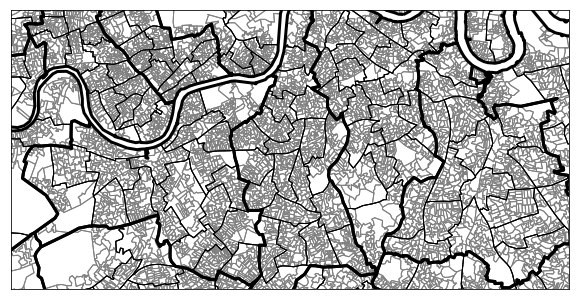

In [12]:
f,ax = plt.subplots(1,1,figsize=(10,10))
output_areas.plot(ax=ax, color='none',edgecolor='gray',lw=1)
wards.plot(ax=ax, facecolor='none',edgecolor='black',lw=1)
boroughs.plot(ax=ax, facecolor='none',edgecolor='black',lw=3)
ax.set_xlim((690000,710000))
ax.set_ylim((5700000,5710000))
ax.set_xticks([])
ax.set_yticks([]);

In [17]:
f.savefig('../figures/borough_ward_oa.png',dpi=300)

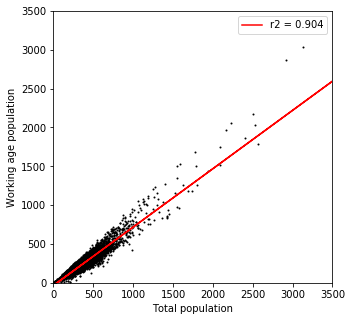

In [18]:
f,ax = plt.subplots(1,1,figsize=(5,5))
x = output_areas.population
y = output_areas.adult_population

ax.set_xlim(0,3500)
ax.set_ylim(0,3500)
ax.set_xlabel('Total population')
ax.set_ylabel('Working age population')

lin = stats.linregress(x,y)
ax.plot(x,x*lin[0] + lin[1],'r-',label=f'r2 = {lin[2]**2:.3}',zorder=10)
ax.legend()
plt.plot(x,y,'k.',markersize=2,zorder=1)

In [19]:
f.savefig('../figures/adult_vs_total_population.png',dpi=300)

In [20]:
# We may lose some data due to mismatch, note it
lost_geom = oa_geom[~oa_geom.oa11cd.isin(output_areas.oa11cd)]
print('In geometry but not in combined data: ',lost_geom.shape[0])
lost_pop = oa_pop[~oa_pop.oa11cd.isin(output_areas.oa11cd)]
print('In census but not in combined data: ',lost_pop.shape[0])

In geometry but not in combined data:  0
In census but not in combined data:  0


In [21]:
# Combine entrances and station locations data
stations = pd.merge(station_geom, entrances, how='inner',left_index=True, right_index=True)
stations['station'] = stations.index

In [22]:
# We lose some data due to mismatch, note it
lost_geom = station_geom[~station_geom.index.isin(stations.index)]
print('In geometry but not in combined data: ',lost_geom.shape[0])
lost_pop = entrances[~entrances.index.isin(stations.index)]
print('In count but not in combined data: ',lost_pop.shape[0])

In geometry but not in combined data:  37
In count but not in combined data:  3


We note that there isn't a perfect match between the station location and station ridership data, as well as between the ward shapes and the ward census data. This is mainly due to small string mismatches. In the future, we will attempt to reconcile as much of the data as we can.

## Spatial preprocessing

The station data operates on a scale of around 1km, corresponding to the walking distance of people to the station, whereas the wards are usually on a scale of multiple kilometers. We therefore need to combine the two datasets so that they operate on the same scales. This is not a trivial task: there is a whole body of research dedicated to interpolating estimates to regions not covered by data. For now, we use the simplest method there is: we estimate the ward population based on the station data whose zone overlaps with that ward. The issues with this will be discussed later.

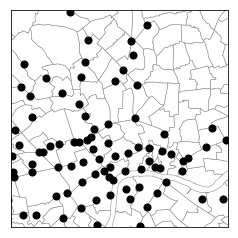

In [23]:
f,ax = plt.subplots(1,1)
wards.plot(color='white', edgecolor='gray', lw=0.5, ax=ax)
stations.set_geometry('location').plot(ax=ax, markersize=50, color='k')
ax.set_xlim((695000,705000))
ax.set_ylim((5708000,5718000))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### Walking zone

Create a "walking zone", e.g. the maximum distance from which passengers are arriving.

In [24]:
# Buffer distance
stations['zone'] = stations.set_geometry('location').buffer(500)

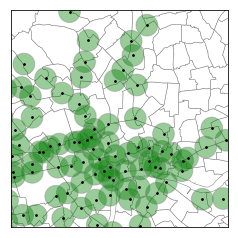

In [25]:
ax = wards.plot(color='white', edgecolor='gray', lw=0.5)
stations.set_geometry('zone').plot(ax=ax, alpha=0.4,edgecolor='gray', color='green')
stations.set_geometry('location').plot(ax=ax, markersize=3, color='k')
ax.set_xlim((695000,705000))
ax.set_ylim((5708000,5718000))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

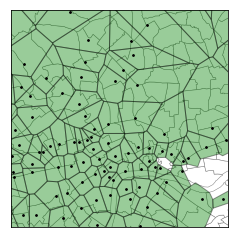

In [26]:
ax = wards.plot(color='white', edgecolor='gray', lw=0.5)
stations.set_geometry('cell').plot(ax=ax, alpha=0.4,edgecolor='k', color='green')
stations.set_geometry('location').plot(ax=ax, markersize=3, color='k')
ax.set_xlim((695000,705000))
ax.set_ylim((5708000,5718000))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Assuming that passengers enter the station nearest to them, we need to limit the extent of the zones to the Vornoi cell of the station. I.e. the zones should not be overlapping with each other.

In [27]:
%%time
# Extract some helpful geometries
shp_london = gpd.read_file('../data/london/shapes/misc/london.shp')
box = shapely.geometry.box(*boroughs.geometry.total_bounds.tolist()).buffer(2000)
box = gpd.GeoDataFrame({'geometry':[box]})
box.crs = stations.crs
external = gpd.overlay(box, boroughs, how='difference')
water = gpd.overlay(external, shp_london, how='intersection')
external = gpd.overlay(external, water, how='difference')
london_nowater = gpd.GeoDataFrame({'geometry':boroughs.union(external)},crs=stations.crs)

/Users/itto/miniconda3/envs/spatial/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:32630', 'no_defs': True} and {'init': 'epsg:32630'}
  other.crs))


CPU times: user 6.26 s, sys: 33.4 ms, total: 6.3 s
Wall time: 6.36 s


In [28]:
# Voronoi cells encompass a large area. Restrict them to London.
stations = gpd.overlay(stations.set_geometry('cell'), box)
stations.rename(columns={'geometry':'cell'},inplace=True)

In [29]:
%%time
# Restrict station zones to land
stations = gpd.overlay(stations.set_geometry('zone'), water, how='difference')
stations = stations.dissolve('station', as_index=False)
stations.rename(columns={'geometry':'zone'},inplace=True)

CPU times: user 6.66 s, sys: 26.6 ms, total: 6.68 s
Wall time: 6.76 s


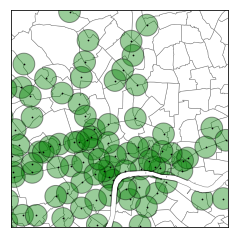

In [30]:
ax = wards.plot(color='white', edgecolor='gray', lw=0.5)
stations.set_geometry('zone').plot(ax=ax, alpha=0.4,edgecolor='black', lw=1, color='green')
stations.set_geometry('location').plot(ax=ax, markersize=0.5, color='k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((695000,705000))
ax.set_ylim((5708000,5718000))
plt.show()

In [31]:
# Restrict zones to be within Voronoi cell
n = stations.shape[0]
stations = gpd.overlay(stations.set_geometry('zone'), stations.loc[:,['station','cell']].set_geometry('cell'))
stations.rename(columns={'geometry':'zone'},inplace=True)
# Each zone overlaps with multiple cells. Only get the cell corresponding to the zone's station.
stations = stations.loc[stations.station_1 == stations.station_2]
# We have duplicate columns. Keep only one. 
stations.drop('station_2',axis=1,inplace=True)
stations.rename(columns={'station_1':'station'},inplace=True)
stations.set_index('station',drop=True,inplace=True)
print('Lost {} rows while overlapping geometries'.format(n - stations.shape[0]))

Lost 1 rows while overlapping geometries


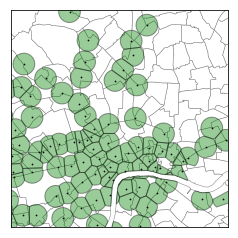

In [32]:
ax = wards.plot(color='white', edgecolor='gray', lw=0.5)
stations.set_geometry('zone').plot(ax=ax, alpha=0.4,edgecolor='black', lw=1, color='green')
stations.set_geometry('location').plot(ax=ax, markersize=0.5, color='k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((695000,705000))
ax.set_ylim((5708000,5718000))
plt.show()

We now have a better designation of the area that is represented by our transit-based population estimate. We next need to collect these estimation areas according to the wards that they represent. This involves splitting estimation areas that span multiple wards, and merging two or more estimation areas that both represent the same ward.

In [37]:
def plot_region(ax, title):
    wards.plot(color='white', edgecolor='gray', lw=0.5, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim((695000,705000))
    ax.set_ylim((5708000,5718000))

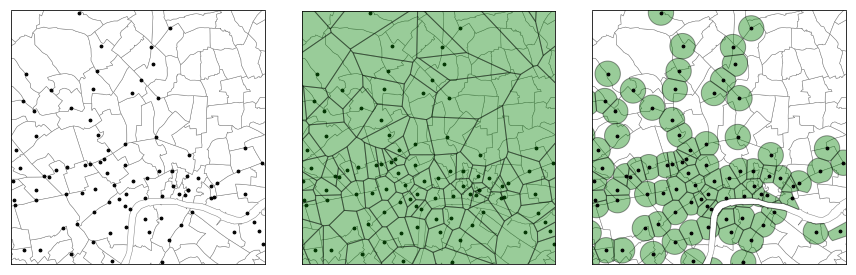

In [48]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,6))
plot_region(ax1,'A')
plot_region(ax2,'B')
plot_region(ax3,'C')

# Station locations
station_geom.set_geometry('location').plot(ax=ax1, markersize=8, color='k')

# Cells
station_geom.set_geometry('location').plot(ax=ax2, markersize=8, color='k')
station_geom.set_geometry('cell').plot(ax=ax2, alpha=0.4,edgecolor='k', color='green')
# stations.set_geometry('location').plot(ax=ax2, markersize=0.5, color='k')

# Zones intersected with cells
# station_geom.set_geometry('location').plot(ax=ax3, markersize=8, color='k')
stations.set_geometry('zone').plot(ax=ax3, alpha=0.4,edgecolor='black', lw=1, color='green')
stations.set_geometry('location').plot(ax=ax3, markersize=8, color='k')

f.tight_layout(w_pad=3)

In [49]:
f.savefig('../figures/station_zones_process.png',dpi=300)

### Helper functions

In [50]:
# meas: area to interpolate from, must contain est_key
# unknown: area to interpolate to
# meas_key: label of area to interpolate from
# unknown_key: label of area to interpolate to
# est_key: label of data to interpolate
def interpolate_count(meas, unknown, meas_key, unknown_key, est_key):
    # Overlap with the unknown area, keep both geometries
    meas = gpd.overlay(meas,unknown, how='union')
    # At this point we have measurements at geometries within the interpolation area
    # and at geometries outside. We need to divide the population count weighted by area
    for i,group in meas.groupby(meas_key):
        # Weight based on area of m out of total area of all measurements
        w = group.area/group.area.sum()
        # Assign the weighted average to the estimate
        meas.loc[meas[meas_key] == i,est_key] = w*group[est_key]
    
    # Return the sum of all counts
    meas.geometry = meas.buffer(0.001) # Hack to avoid dissolving issues
    return meas.dissolve(unknown_key, aggfunc='sum', as_index=False)

In [51]:
# meas: area to interpolate from, must contain est_key
# unknown: area to interpolate to
# meas_key: label of area to interpolate from
# unknown_key: label of area to interpolate to
# est_key: label of data to interpolate
def interpolate_rate(meas, unknown, meas_key, unknown_key, est_key):
    # Overlap with the unknown area, discard non-overlapping areas
    meas = gpd.overlay(meas,unknown, how='intersection')

    # Now we have multiple measurements per interpolation area. We need to
    # average the measurements, weighted based on area coverage
    for i,group in meas.groupby(unknown_key):
        # Get weight based on area of measurement out of total area of all measurements
        w = group.area/group.area.sum()
        # Assign the weighted average to the estimate
        meas.loc[meas[unknown_key] == i,est_key] = w*group[est_key]

    # Done interpolation. Dissolve.
    meas.geometry = meas.buffer(0.001) # Hack to avoid dissolving issues
    return meas.dissolve(unknown_key, aggfunc='sum', as_index=False)

Different metrics to try out. Some represent the demand in the morning, others are attempts to get the population.

In [52]:
# am peak / (mean of off peak + am peak)
def model1(morning,afternoon,off,night):
    prob = morning.max()/(off.mean()+morning.max())
    return prob*morning.sum()

# Morning_max / (mean of off peak + morning max)
def model2(morning,afternoon,off,night):
    return morning.sum()+off.sum()*0.33+night.sum()*0.5


def model3(morning,afternoon,off,night):
    return morning.max()/off.mean()*morning.sum()

def model4(morning,afternoon,off,night):
    return morning.sum()

# Focus on offpeak activity. CBD's are more active in the middle of the day.
def model5(morning,afternoon,off,night):
    return off.sum()

def get_workbound(morning,afternoon,off,night):
    # Subtract the trapezoid
    return morning.sum() - ((morning.iloc[0] + morning.iloc[-1]) * morning.shape[0] / 2)

def get_homebound(morning,afternoon,off,night):
    # Subtract the trapezoid
    return afternoon.sum() - ((afternoon.iloc[0] + afternoon.iloc[-1]) * afternoon.shape[0] / 2)

In [53]:
%%latex
\begin{align}
R_{workbound} = \sum_{i=6AM}^{10AM} (R_i - R_{i_{miscellaneous}}) ,\hspace{10mm}(1)
\end{align}

<IPython.core.display.Latex object>

In [54]:
import matplotlib.dates as mdates

In [55]:
def plot_workbound(station,ax):
    morning = data_en.loc[time_of_day=='morning',station]
    afternoon = data_en.loc[time_of_day=='afternoon',station]
    off = data_en.loc[time_of_day=='off',station]
    
    # Plot ridership
    data_en[station].plot(color='k',ax=ax)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    
    # Add miscellaneous line for morning
    x = [data_en.loc[time_of_day=='morning'].index[0],data_en.loc[time_of_day=='morning'].index[-1]]
    y = [data_en.loc[time_of_day=='morning'][station][0],data_en.loc[time_of_day=='morning'][station][-1]]
    ax.plot(x,y,'k--')
    # Color the morning segments
    ax.fill_between(morning.index,morning, color='C2')
    ax.fill_between(x,y, color='C0',lw=2)
    # Add miscellaenous line for afternoon
    x = [data_en.loc[time_of_day=='afternoon'].index[0],data_en.loc[time_of_day=='afternoon'].index[-1]]
    y = [data_en.loc[time_of_day=='afternoon'][station][0],data_en.loc[time_of_day=='afternoon'][station][-1]]
    ax.plot(x,y,'k--')
    # Color the afternoon segments
    ax.fill_between(afternoon.index,afternoon, color='C1')
    ax.fill_between(x,y, color='C0',lw=2)
    # Color all of miscellaneous
    ax.fill_between(off.index,off, color='C0',lw=2)
    
    
    ax.set_xlabel('Time (hour)')
    ax.set_ylabel('Number of entrances')
    
    
    return ax

In [56]:
a = data_en.copy()
a = a[['Borough','Oxford Circus','Brixton']]
a['time_of_day'] = time_of_day
a.to_csv('/Users/itto/Downloads/4abc.csv')

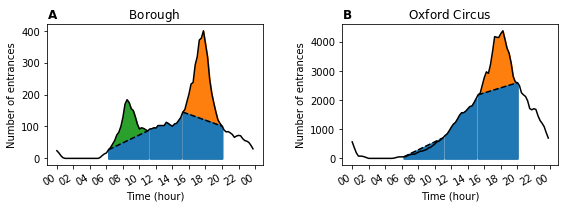

In [57]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
plot_workbound('Borough',ax1)
ax1.set_title(r"$\bf{A}$                   Borough", loc='left')
plot_workbound('Oxford Circus',ax2)
ax2.set_title(r"$\bf{B}$               Oxford Circus", loc='left')

f.tight_layout(w_pad=3)

In [58]:
f.savefig('../figures/ridership_model_example.png',dpi=300)

This model is not perfect... We should asjut the morning and afternoon hours. Even better, we should adapt the morning/evening hours to match the peaks of the individual stations (based on gradients, etc.).

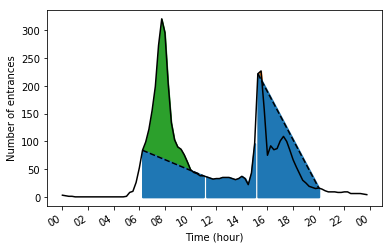

In [60]:
f,(ax) = plt.subplots(1,1)
plot_workbound('Rickmansworth',ax)

That being said, is good enough for now. It gives us a rough estimate of morning and afternoon riders.

In [65]:
workbound = get_workbound(data_en.loc[time_of_day=='morning'],
             data_en.loc[time_of_day=='afternoon'],
             data_en.loc[time_of_day=='off'],
             data_en.loc[time_of_day=='night'])

In [66]:
homebound = get_homebound(data_en.loc[time_of_day=='morning'],
             data_en.loc[time_of_day=='afternoon'],
             data_en.loc[time_of_day=='off'],
             data_en.loc[time_of_day=='night'])

In [67]:
stations['workbound'] = workbound.reindex(stations.index) 

In [68]:
stations['homebound'] = homebound.reindex(stations.index) 

## Underperforming Stations

We begin by making a large assumption: the morning ridership of all stations is the same. That is, the percentage of people living within a station's zone (e.g. 500m radius) who commute to work via the TfL network is the same for all stations. If this assumption is true, then we should see a very clear linear relationship between the number of people commuting to work every morning and the population of the station's zone.

In [69]:
%%latex
\begin{align}
R_{workbound} = \alpha P ,\hspace{10mm}(3)       
\end{align}

<IPython.core.display.Latex object>

In [70]:
%%time
pop_interpolated = interpolate_count(
    output_areas,
    stations.reset_index().set_geometry('zone'),
    'oa11cd',
    'station',
    'adult_population'
)
# Remove values where there are no estimations
pop_interpolated = pop_interpolated.loc[pop_interpolated.population > 0]

CPU times: user 3min 54s, sys: 2.12 s, total: 3min 57s
Wall time: 4min 3s


In [71]:
data = pop_interpolated.set_index('station').copy()

In [72]:
data.workbound = stations.workbound
data.homebound = stations.homebound

Text(0.5, 0, 'Station zone population')

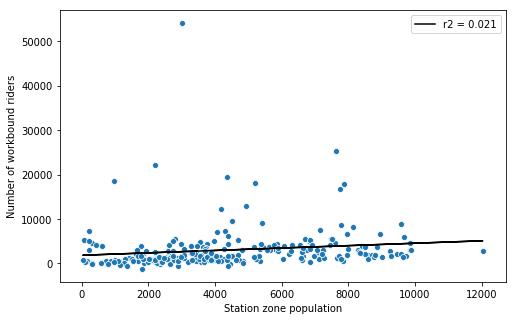

In [83]:
f,(ax1) = plt.subplots(1,1, figsize=(8,5), sharey=False)
x = data.adult_population
y = data.workbound
lin = stats.linregress(x,y)
ax1.plot(x,lin[0]*x+lin[1],'k',label = f'r2 = {lin[2]**2:.3f}')
ax1.legend()
sns.scatterplot(x,y,zorder=0)
ax1.set_ylabel('Number of workbound riders')
ax1.set_xlabel('Station zone population')

In [84]:
f.savefig('../figures/population_correlation.png',dpi=300)

In [85]:
data[['adult_population','workbound','homebound']].to_csv('../data/output/population_correlation.csv',index=False)

In [86]:
data['ridership'] = (lin[0]*x+lin[1])/x

The relationship, though significant, is very error-prone. For a given station population, we either significantly overestimate or underestimate the number of commuters. This is because our assumption of equal ridership at all stations is incorrect. In reality, some areas will have higher percentage ridership than others. The reasons for this are numerous. First, the number of workers commuting to their workplace (i.e. working away from home) is not constant; some areas will have more work opportunities closer to home than others. Second, even if a worker does commute to their workplace, they may do so through other means (car, bus, bicycle). Lastly, a commuter who does take the train in the morning, may do so through other stations, not necessarily the station closest to them. Likewise, the commuters who do enter a specific station may not necessarily be living there.

We need a new model to take this into account. The new model should account for the fact that the ridership (alpha) depends on the station location. It should also account for the fact that riders are coming from other areas and leaving to other areas.

In [87]:
%%latex
\begin{align}
R_{workbound} = \alpha_s P + R_{fromElsewhere} - R_{toElsewhere} ,\hspace{10mm}(4) 
\end{align}

<IPython.core.display.Latex object>

With this new model in mind, we can describe the errors in our regression as the difference between the two models.

In [88]:
%%latex
\begin{align} 
\epsilon =  R_{fromElsewhere} - R_{toElsewhere} + (\alpha_s - \alpha_{mean})P .\hspace{10mm}(5)
\end{align}

<IPython.core.display.Latex object>

Thus, the error actually represents some critical properties of the system. A large error can represent one of two things: a large number of riders coming from other areas, or a larger than expected percentage of inhabitants taking the train. On the other hand, a large negative error represents the opposite: many inhabitants taking the train somewhere else, or fewer than expected inhabitants taking the train at all. Essentially, the error in the regression is not an error at all, but rather a description of how well the station performs.

However, a large negative error does not necessarily indicate that a station is performing poorly. Though it may mean that are "escaping" to other stations or that they are using other modes of transport, it could also mean that riders are simply less nomadic; they may be working in the same area that they live. Thus, before we can use the error as a metric for the success of a station, we need to separate the two phenomena.

This would be easier with more datasets. For example, if we had the locations of businesses in London, we would expect to see more that some stations with negative error have many businesses nearby, suggesting that workers do not take the train because they work nearby. If we had other mobility data, such as car, bike, and bus, we would would expect to see that riders are using other means of transport to get to work, or at the very least they are using them to get to other stations.

### Error analysis

However, we do not have access to this data. Therefore we can only show this in abstract. Instead, we will show that out of the stations with negative error, some show patterns that would suggest a higher ridership, whereas others show patterns that would suggest a lower ridership. To do this, we will first show how the "pattern" of the hourly entrances is indicative of the the number of riders.

In [89]:
e = y - (lin[0]*x+lin[1])
eunder = e[e<0]
eover = e[e>0]

data['error'] = e

In [90]:
data['error_abs'] = data.error.abs()

In [91]:
data['residentiality'] = data_en.loc[time_of_day == 'morning'].max() / data_en.loc[time_of_day == 'off'].mean()

No handles with labels found to put in legend.


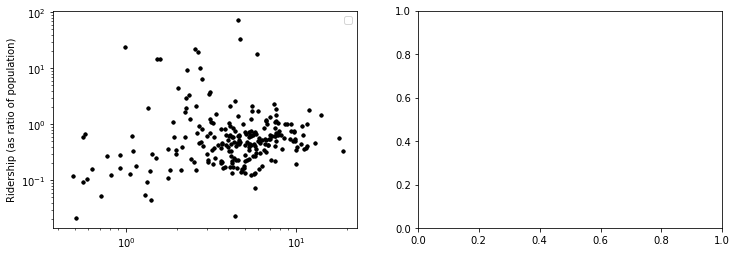

In [92]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharey=False)
x = data.residentiality
# x[x < 1] = -x[x<1]
y = data.workbound/data.adult_population
ax1.plot(x, y, 'k.')

lin = stats.linregress(x,y)
# ax1.plot(x,lin[0]*x+lin[1], 'r.',label = f'r2 = {lin[2]**2}')
ax1.legend()
ax1.set_ylabel('Ridership (as ratio of population)')
ax1.loglog(x,y,'k.',zorder=0)
# ax1.set_ylim(-0.5,2)

# x = x[y <= 2]
# y = y[y <= 2]
# x = x[y >= -2]
# y = y[y >= -2]
# # y = y[x >= 0]
# # x = x[x >= 0]
# lin = stats.linregress(x,y)
# ax2.plot(x,lin[0]*x+lin[1], label = f'r2 = {lin[2]**2}')
# ax2.legend()
# ax2.plot(x,y,'k.')
# f.tight_layout()
# f.suptitle('Ridership vs. the ratio of morning to off-peak entrances', y=1.05);

In [93]:
lin

LinregressResult(slope=-0.11863604155704525, intercept=2.1201806575081248, rvalue=-0.0627782376891792, pvalue=0.3228529726426812, stderr=0.11976342173756181)

The above regression shows us that the ridership is correlated with the "sharpness" of the morning peak. Sharper stations, *regardless of their absolute number of riders*, are expected to have a higher ridership than stations with "dull" or non-existent peaks. We can use this to show the two types of phenomena resulting in underperforming stations. Namely, we show that out of the underperforming stations, some would actually be expected to perform well judging by their hourly entrance pattern.

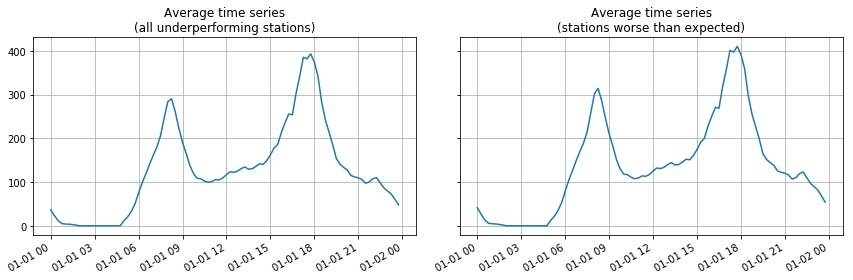

In [94]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True)

data_en.T.loc[eunder.index].mean().plot(ax=ax1)
ax1.set_title('Average time series\n(all underperforming stations)');

ridership_expected = data.reindex(eunder.index).residentiality*lin[0]+lin[1]
ridership_actual = data.reindex(eunder.index).ridership
underperformers = ridership_expected.loc[ridership_expected > ridership_actual].index
data_en.T.loc[underperformers].mean().plot(ax=ax2)
ax2.set_title('Average time series\n(stations worse than expected)');
f.tight_layout()

ax1.grid()
ax2.grid()

This proves that out of the underperforming stations, some are expected to be underperforming, whereas others we would expect to perform much better. Moreover, we show that those stations which do not meet expectations are smaller and more residential than the average station. In essence, these are the stations which are truly performing poorly, as these are the stations who do not just have a small number of riders, but also have a pattern indicative of a demand that is higher than we observe.

### Degree analysis

Does the population correlation error correlate with the degree of the nodes? One would expect stations connecting multiple lines (degree > 2) and temrinal stations (degree = 1) to be more imoortant and therefore to receive more entrances from other regions. This would result in a worse population correlation than for "standard" stations (degree = 2).

In [66]:
nodes = pd.read_csv('../data/london/network/nodes.csv')

In [67]:
lines = pd.read_csv('../data/london/network/lines.csv')

In [88]:
network = pd.merge(nodes[['id','name']],lines,left_on='id',right_on='station1')

In [104]:
network['degree'] = network.station1.map(network.groupby('station1').station2.nunique())

In [105]:
degree = network.groupby('name').first().degree

In [109]:
data['degree'] = degree
data.degree.fillna('none',inplace=True)

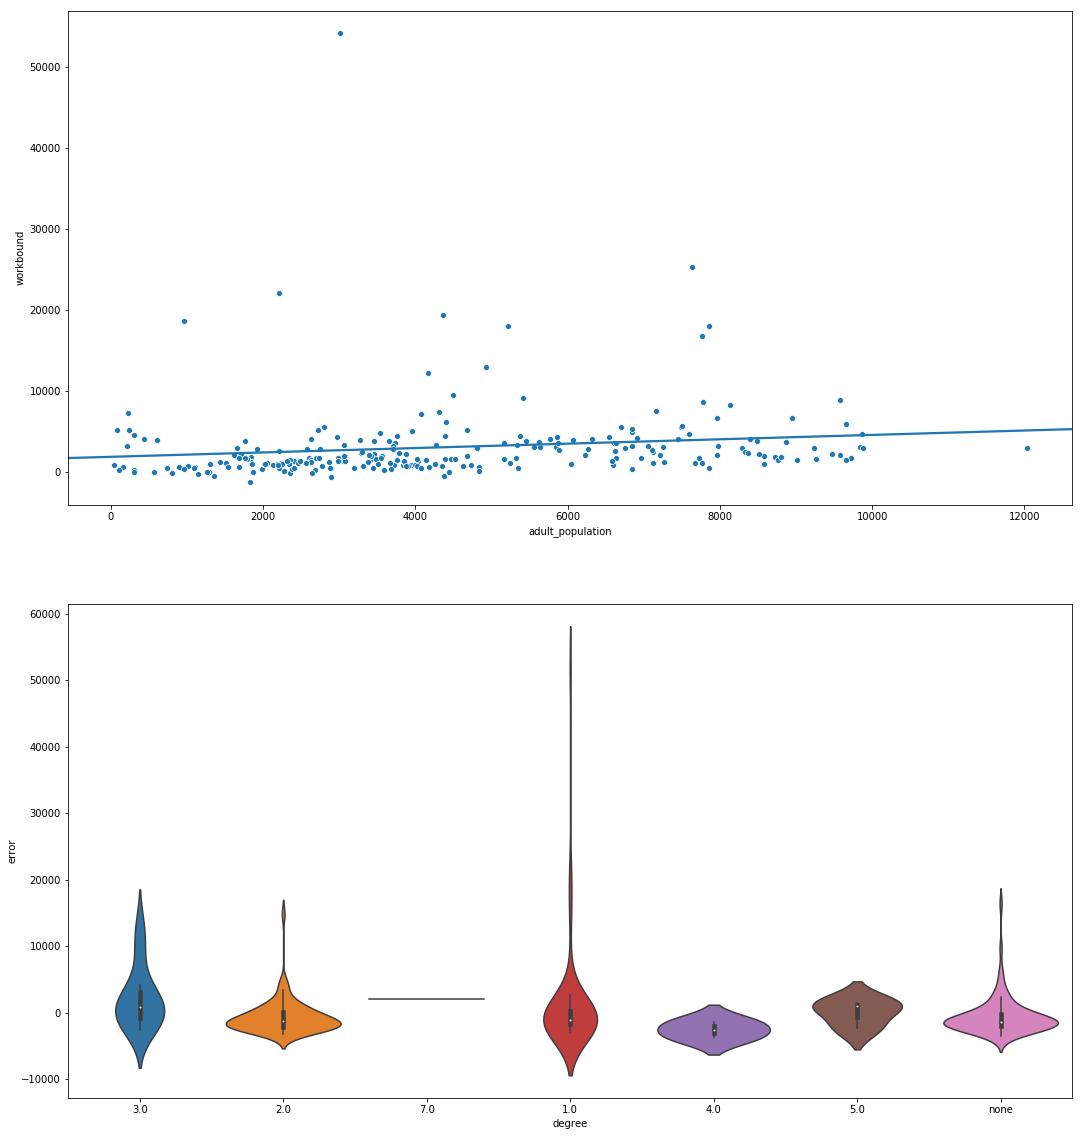

In [110]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(18,20))
sns.scatterplot('adult_population','workbound',data=data,ax=ax1)
sns.regplot(data.adult_population,data.workbound,ci=None,scatter=False,ax=ax1)
sns.violinplot(data.degree,data.error,ax=ax2)

# Display

Random visualizations used for a presentation. Ignore for now.

In [112]:
%%time
disp1 = gpd.overlay(stations.set_geometry('cell').reset_index(), shp_london).dissolve('station')

/Users/itto/miniconda3/envs/spatial/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:32630', 'no_defs': True} and {'init': 'epsg:32630'}
  other.crs))


CPU times: user 3.6 s, sys: 23.1 ms, total: 3.62 s
Wall time: 3.63 s


In [114]:
disp1['morning_ratio'] = disp1.morning / (disp1.off)
disp1['afternoon_ratio'] = disp1.afternoon / (disp1.morning+disp1.night+disp1.afternoon+disp1.off)

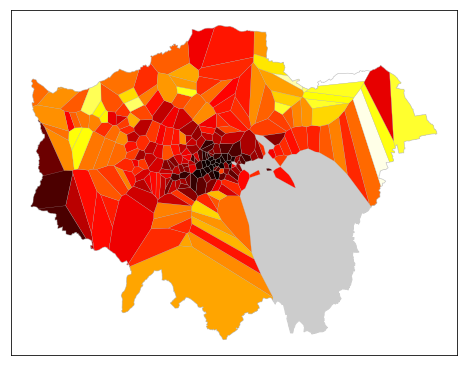

In [116]:
ax = shp_london.plot(color=[0.8,0.8,0.8], edgecolor=[0.8,0.8,0.8], figsize=(8,8))
disp1.plot( ax=ax, column='morning_ratio', edgecolor =[0.7,0.7,0.7], lw = 0.2,cmap='hot')
ax.set_xticks([])
ax.set_yticks([]);

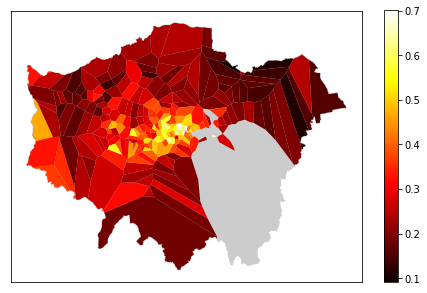

In [117]:
ax = shp_london.plot(color=[0.8,0.8,0.8], edgecolor=[0.8,0.8,0.8], figsize=(8,5),legend=True)
disp1.plot(ax=ax, column='afternoon_ratio',lw=0.2,cmap='hot',legend=True)
ax.set_xticks([])
ax.set_yticks([]);

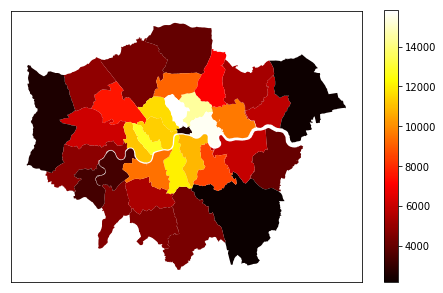

In [118]:
ax = boroughs.plot(column='density_actual', cmap='hot', figsize=(8,5), legend=True)
ax.set_xticks([])
ax.set_yticks([]);

In [119]:
import matplotlib.dates as mdates

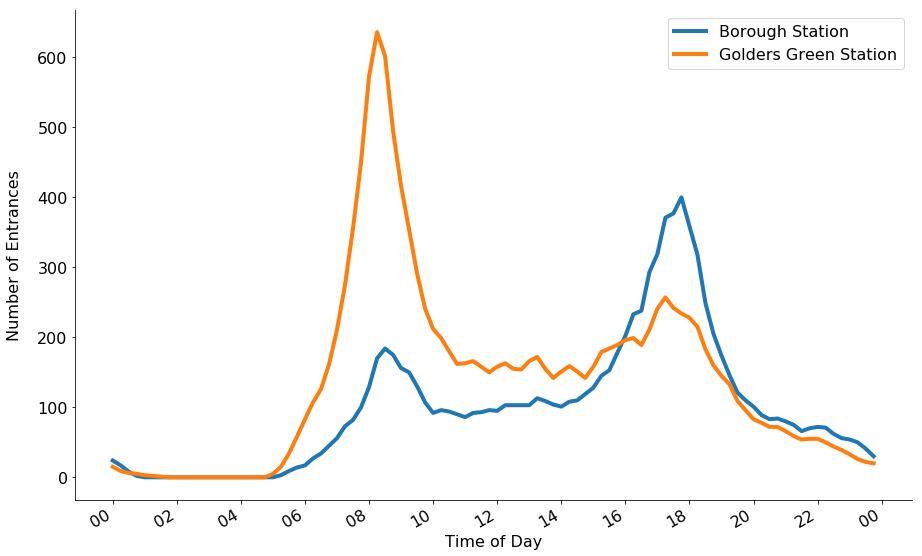

In [120]:
plt.rcParams.update({'font.size': 16})
for station in ['Borough','Golders Green']:
    ax = data_en.loc[:,station].plot(lw=4, figsize=(15,10), label=station+' Station')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    # ax.yaxis.grid()
    # ax.xaxis.grid()
    ax.locator_params(axis='y', nbins=7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Number of Entrances', labelpad=15)
#     ax.set_title('Station entrances on a weekday',pad=20,fontdict={'fontsize':20})
plt.legend()
plt.savefig('/Users/itto/Desktop/entrances.png')

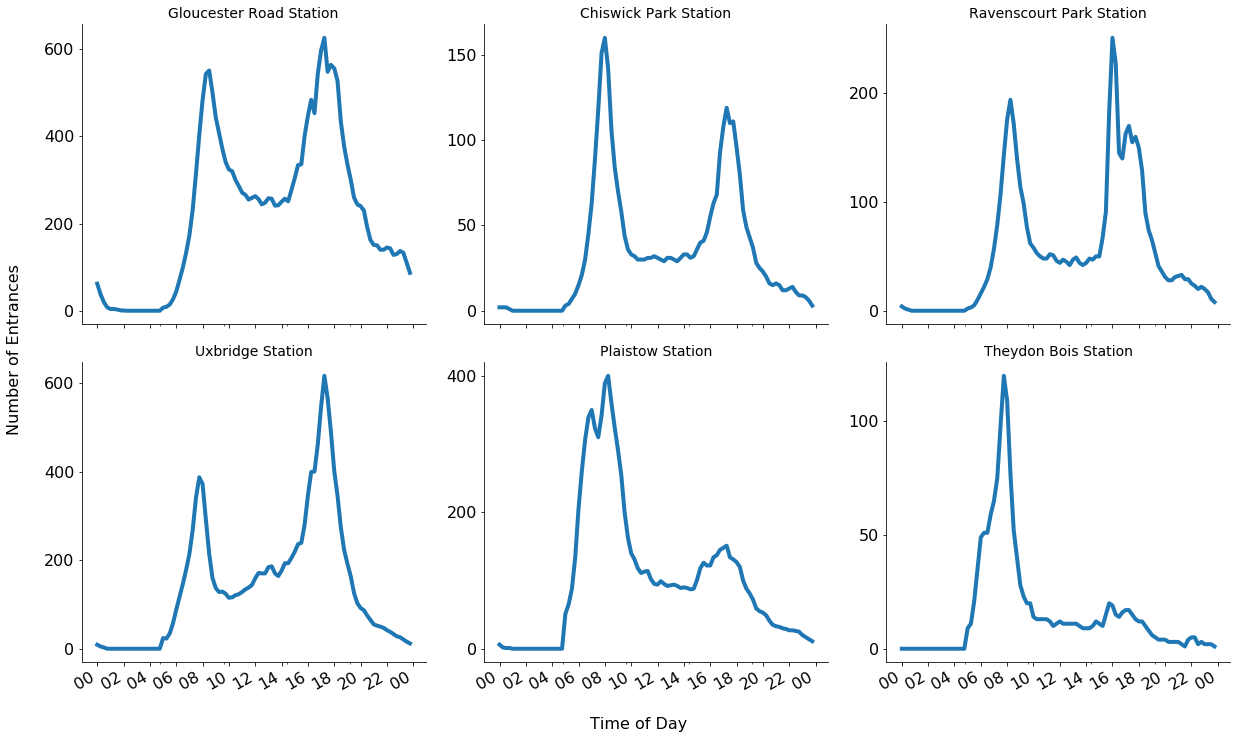

In [208]:
montage = data_en.sample(6,axis=1,random_state=42)
f,axes = plt.subplots(2,3,figsize=(17,10),sharex=True,sharey=False)
axes = axes.flatten()
for i,ax in enumerate(axes):
    montage.iloc[:,i].plot(ax=ax, lw=4)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.locator_params(axis='y', nbins=4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(montage.columns[i]+' Station',fontdict={'fontsize':14})
f.text(-0.01, 0.5, 'Number of Entrances', ha='center', va='center', rotation='vertical')
f.text(0.5, -0.02, 'Time of Day', ha='center', va='center')
f.tight_layout()

In [344]:
nodes = pd.read_csv('../data/london/network/nodes.csv')
nodes['geometry'] = [shapely.geometry.Point(p) for p in list(zip(nodes.longitude.values, nodes.latitude.values))]
nodes = gpd.GeoDataFrame(nodes)
nodes.crs = {'init' :'epsg:4326'}
nodes.to_crs(epsg= PROJECTION, inplace=True)

In [345]:
node_map = nodes.set_index('id')['geometry'].to_dict()

In [346]:
lines = pd.read_csv('../data/london/network/lines.csv')
lines['point1'] = lines.station1.map(node_map)
lines['point2'] = lines.station2.map(node_map)
lines = gpd.GeoDataFrame(lines)
lines.crs = nodes.crs

In [347]:
lines['geometry'] = ([shapely.geometry.LineString([p1,p2]) for (p1,p2) in lines[['point1','point2']].values])

In [112]:
entrances['total'] = entrances.afternoon + entrances.night + entrances.off + entrances.morning
entrances['morning_max'] = data_en.loc[time_of_day == 'morning'].max()
entrances['afternoon_max'] = data_en.loc[time_of_day == 'afternoon'].max()
entrances['off_mean'] = data_en.loc[time_of_day == 'off'].mean()

In [497]:
ratio_morn = (entrances.morning_max / entrances.off_mean)
ratio_afternoon = (entrances.afternoon_max / entrances.off_mean)

In [498]:
# Get all stations above the zero intersection
hotspots_work = ratio_afternoon.sort_values().iloc[x[tangent_zero:]].index
hotspots_work = stations.reindex(hotspots_work)
hotspots_work.dropna(subset=['location'],inplace=True)

In [499]:
# Get all stations above the zero intersection
hotspots_res = ratio_morn.sort_values().iloc[x[tangent_zero:]].index
hotspots_res = stations.reindex(hotspots_res)
hotspots_res.dropna(subset=['location'],inplace=True)

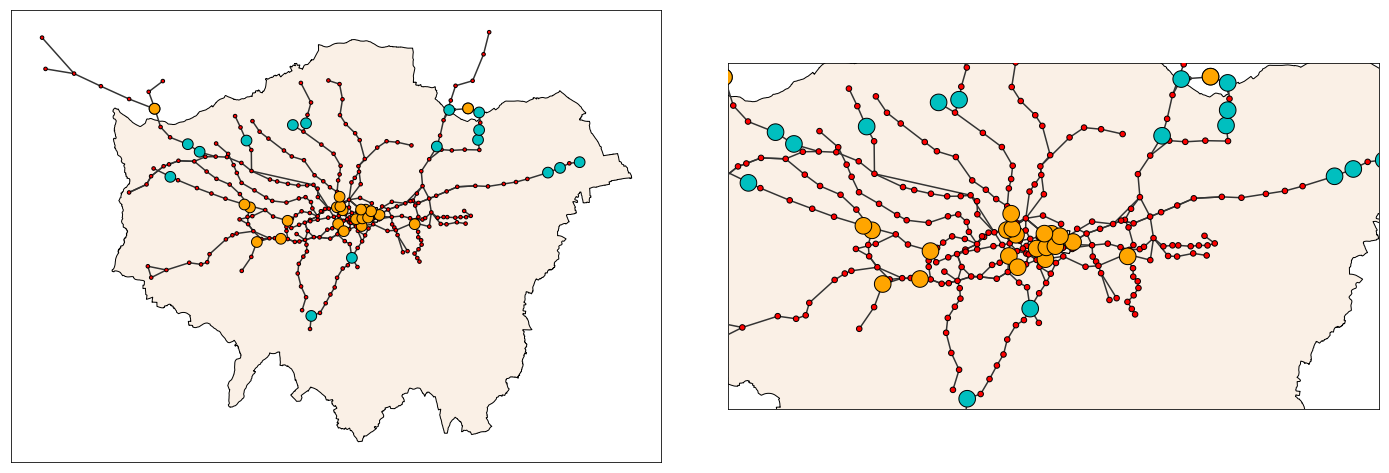

In [513]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,12))
shp_london.plot(ax=ax1,color='linen',edgecolor='k',zorder=0)
# hotspots_res.set_geometry('zone').plot(ax = ax1,color='c',alpha=0.5,zorder=1)
# hotspots_work.set_geometry('zone').plot(ax = ax1,color='orange',zorder=1)
lines.plot(ax=ax1, color=[0.2,0.2,0.2], zorder=4)
nodes.buffer(200).plot(ax=ax1, edgecolor='k', color='r', zorder=5)
hotspots_res.set_geometry('location').buffer(600).plot(ax=ax1, edgecolor='k', color='c', zorder=5)
hotspots_work.set_geometry('location').buffer(600).plot(ax=ax1, edgecolor='k', color='orange', zorder=5)
ax1.set_xticks([])
ax1.set_yticks([])
# Zoom in
shp_london.plot(ax=ax2,color='linen',edgecolor='k',zorder=0)
# hotspots_res.set_geometry('zone').plot(ax = ax2,color='c',alpha=0.5,zorder=1)
# hotspots_work.set_geometry('zone').plot(ax = ax2,color='orange',zorder=1)
lines.plot(ax=ax2, color=[0.2,0.2,0.2], zorder=4)
nodes.buffer(200).plot(ax=ax2, edgecolor='k', color='r', zorder=5)
hotspots_res.set_geometry('location').buffer(600).plot(ax=ax2, edgecolor='k', color='c', zorder=5)
hotspots_work.set_geometry('location').buffer(600).plot(ax=ax2, edgecolor='k', color='orange', zorder=5)

ax2.set_xlim((678000,725000))
ax2.set_ylim((5699000,5724000))
ax2.set_xticks([])
ax2.set_yticks([])

f.tight_layout(w_pad=2)